# Ant Colony Optimization (ACO)

Desenvolvido por Airton Soares (https://github.com/saitama-the-coder/PyAnts)


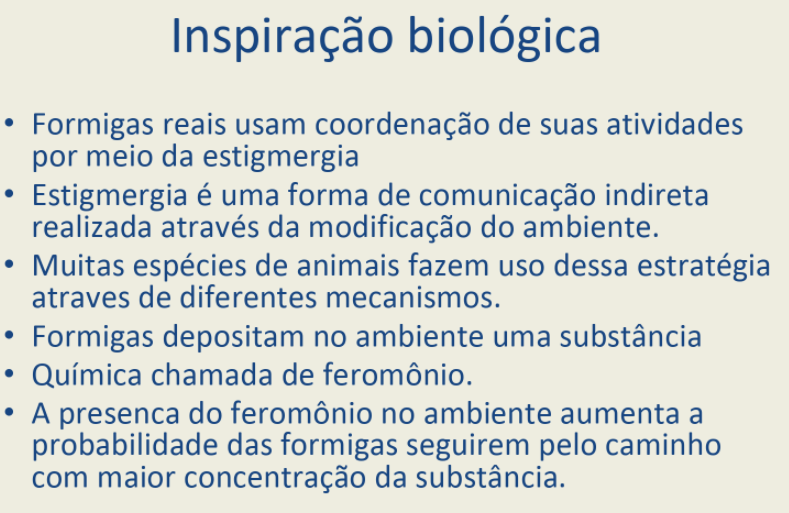

In [29]:
from numpy.random import choice
from scipy import spatial

import matplotlib.pyplot as plt
import random
import math

## Formiga

As formigas são as unidades base da otimização. Elas são responsáveis por depositar feromônio pelos caminhos que percorrem para indicar a qualidade dos mesmo.

In [30]:
class Formiga:
  def __init__(self, ponto_atual):
    self.ponto_atual = ponto_atual
    self.rota = [ponto_atual]

  def andar(self, ponto):
    self.ponto_atual = ponto
    self.rota.append(ponto)

## Grafo

O grafo é a representação de um conjunto de pontos ligados por caminhos. Para este exemplo irei criar as classes "Ponto" (representa uma coordenada no espaço), "Caminho" (ligação entre dois pontos) e "Grafo" (conjunto de caminhos).

In [31]:
class Ponto:
    def __init__(self, x, y):
        self.x = x
        self.y = y

In [32]:
class Caminho:
    def __init__(self, ponto_i, ponto_j):
        self.ponto_i = ponto_i
        self.ponto_j = ponto_j
        self.comprimento = math.sqrt((ponto_i.x - ponto_j.x)**2 + (ponto_i.y - ponto_j.y)**2)
        self.feromonio = 0
        self.formigas_passantes = []

    def contem(self, formiga, qtd_pontos):
        if self.ponto_i == formiga.ponto_atual:
            return self.ponto_j not in formiga.rota or (len(formiga.rota) == qtd_pontos and self.ponto_j == formiga.rota[0])
        elif self.ponto_j == formiga.ponto_atual:
            return self.ponto_i not in formiga.rota or (len(formiga.rota) == qtd_pontos and self.ponto_i == formiga.rota[0])
        else:
            return False

    def ponto_adjacente(self, ponto):
        if self.ponto_i == ponto:
            return self.ponto_j
        elif self.ponto_j == ponto:
            return self.ponto_i
        else:
            return None

In [33]:
class Grafo:
    def __init__(self, caminhos):
        self.caminhos = caminhos
        self.melhor_rota = []

    def possiveis_caminhos(self, formiga, qtd_pontos):
        return [caminho for caminho in self.caminhos if caminho.contem(formiga, qtd_pontos)]

## Atributos do ACO

*   **Tamanho da colônia (n)**: quantidade de formigas na colônia.
*   **Coeficiente de evaporação (p)**: taxa de evaporação do feromônio nos caminhos.
*   **Importância do feromônio (alfa)**: coeficiente que indica o grau de importância que a quantidade de feromônio terá para determinar a probabilidade de escolha de um caminho.
*   **Importância heurística (beta)**: coeficiente que indica o grau de importância que o comprimento do caminho terá para determinar a probabilidade de escolha de um caminho.

In [34]:
n = 8
p = 0.2
alfa = 0.5
beta = 1
iteracoes = 10 # quantidade de iterações que irão acontecer até a parada da otimização

## O problema

Para esse exemplo iremos encontrar a melhor rota (menor distância total) que percorre todos os pontos de um grafo gerado aleatoriamente e completamente conectado (cada ponto tem um caminho par todos os outros).

In [35]:
qtd_pontos = 8 # quantidade de pontos do grafo que será gerado

## Inicialização do grafo


In [36]:
# criando os pontos
pontos = []

for _ in range(qtd_pontos):
    pontos.append(Ponto(random.uniform(-100, 100), random.uniform(-100, 100)))

# criando os caminhos
caminhos = []

for i in range(qtd_pontos - 1):
    ponto_atual = pontos[i]
    pontos_para_conectar = pontos[i + 1:]

    for ponto_para_conectar in pontos_para_conectar:
        caminhos.append(Caminho(ponto_atual, ponto_para_conectar))

# criando o grafo
grafo = Grafo(caminhos)


## Grafo criado

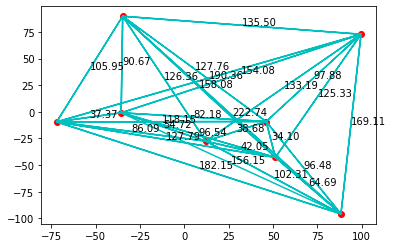

In [37]:
for ponto in pontos:
    plt.plot(ponto.x, ponto.y, marker='o', color='r')

x = []
y = []

for caminho in caminhos:
    x_i = caminho.ponto_i.x
    x_j = caminho.ponto_j.x
    y_i = caminho.ponto_i.y
    y_j = caminho.ponto_j.y

    x_texto = (x_i + x_j) / 2
    y_texto = (y_i + y_j) / 2

    plt.text(x_texto, y_texto, "{:.2f}".format(caminho.comprimento))

    x.append(x_i)
    x.append(x_j)
    y.append(y_i)
    y.append(y_j)

plt.plot(x, y, color='c')

plt.show()

## Inicialização da colônia


In [38]:
def inicializar_colonia():
    formigas = []

    for _ in range(n):
        formigas.append(Formiga(random.choice(pontos)))

    return formigas

## Escolha do caminho

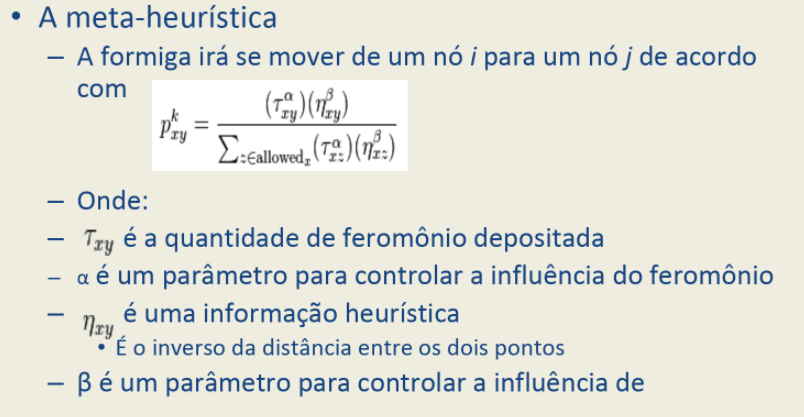

In [39]:
def escolher_caminho(possiveis_caminhos):
    denominador = sum([(caminho.feromonio)**alfa * (1 / caminho.comprimento)**beta for caminho in possiveis_caminhos])
    distribuicao_probabilidades = None

    if denominador == 0:
        distribuicao_probabilidades = [1 / len(possiveis_caminhos)  for _ in possiveis_caminhos]
    else:
        distribuicao_probabilidades = [((caminho.feromonio)**alfa * (1 / caminho.comprimento)**beta) / denominador for caminho in possiveis_caminhos]

    return choice(possiveis_caminhos, 1, p=distribuicao_probabilidades)[0]

## Atualização de feromônio

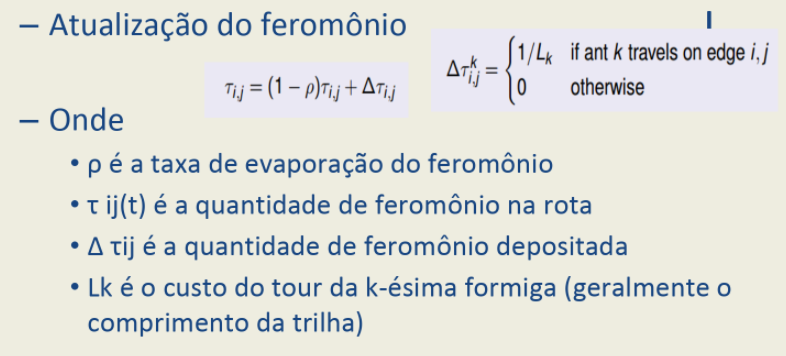

In [40]:
def distancia_rota(rota):
    distancia_rota = 0

    for i in range(0, len(rota) - 1):
        distancia = math.sqrt((rota[i].x - rota[i + 1].x)**2 + (rota[i].y - rota[i + 1].y)**2)
        distancia_rota += distancia

    return distancia_rota

def atualizar_feromonios(caminhos):
    for caminho in caminhos:
        soma_heuristica = sum([1 / distancia_rota(formiga.rota) for formiga in caminho.formigas_passantes])
        caminho.feromonio = (1 - p) * caminho.feromonio + soma_heuristica
        caminho.formigas_passantes = []

## Movimentação da formiga


In [41]:
def movimentar_formiga(formiga, grafo):
    while True:
        possiveis_caminhos = grafo.possiveis_caminhos(formiga, qtd_pontos)

        if possiveis_caminhos == []:
            break

        caminho_escolhido = escolher_caminho(possiveis_caminhos)
        caminho_escolhido.formigas_passantes.append(formiga)
        formiga.andar(caminho_escolhido.ponto_adjacente(formiga.ponto_atual))

## Otimização

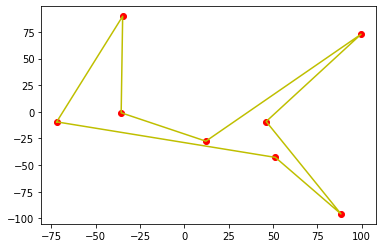

771.35


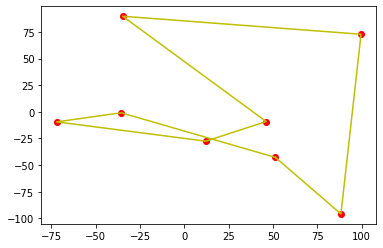

755.72


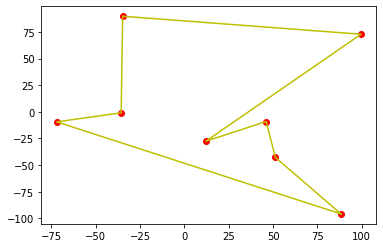

716.32


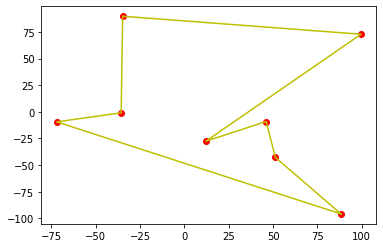

716.32


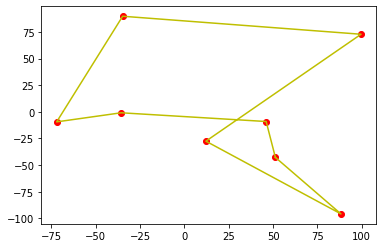

695.27


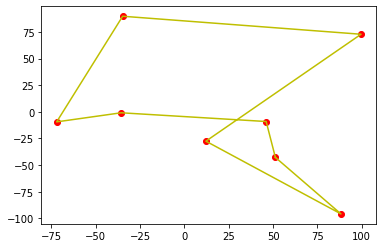

695.27


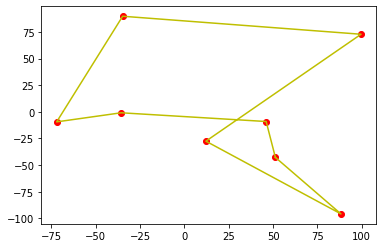

695.27


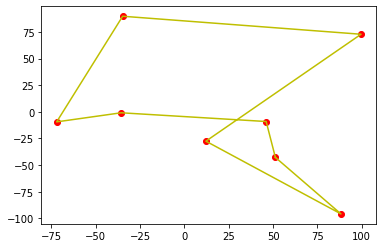

695.27


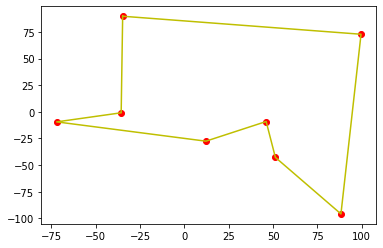

656.19


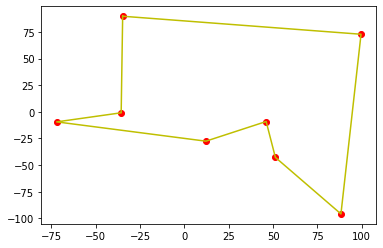

656.19


In [42]:
melhor_rota = None
distancia_melhor_rota = 0

for _ in range(iteracoes):
    formigas = inicializar_colonia()

    for formiga in formigas:
        movimentar_formiga(formiga, grafo)

        if melhor_rota is None or distancia_rota(melhor_rota) > distancia_rota(formiga.rota):
            melhor_rota = formiga.rota
            distancia_melhor_rota = distancia_rota(formiga.rota)

        atualizar_feromonios(grafo.caminhos)

        # mostrando a melhor rota a cada iteracao
        for ponto in pontos:
        plt.plot(ponto.x, ponto.y, marker='o', color='r')

        x = []
        y = []



        for ponto in melhor_rota:
            x.append(ponto.x)
            y.append(ponto.y)

        plt.plot(x, y, color='y')

        plt.show()
        print("{:.2f}".format(distancia_melhor_rota))
